In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn import svm
import pandas as pd
from scipy.stats import norm
from scipy.signal import savgol_filter
import seaborn as sns
import mne
from mne.stats.regression import linear_regression_raw, linear_regression

In [11]:
# function to find index of nearest value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# from Jorie
def sync_timing(df, sync_val, timingname='timing', new_timingname='timing_meg',
                              timingname_offset='timing_offset', new_timingname_offset='timing_offset_meg'):
    """use syncing value to get timings from stimpc domain into the MEG clock domain
    input df and sync value, returns adjusted dataframe"""

    # create new column in old dataframe
    df[new_timingname] = df[timingname] + sync_val
    df[new_timingname_offset] = df[timingname_offset] + sync_val
    # and return
    return(df)

## MOVE FUNCTIONS FROM STIMULUS DOMAIN INTO TIMEDOMAIN
## MAP 'STIMULUS' TO INDEX OF WHAT STIMULI, FOR EASY MAPPING

def stim_save_segments(df_beh, groupby_nm=['block', 'segment']):
    """apply a new column to behavioural dataframe with segment_all - 
    indicating a continious numerical indicator of what segment we are on"""

    # predefine segement all in df_beh
    df_beh['segment_all'] = np.nan
    
    # loop over block and segment combinations
    for idx, row in df_beh.groupby(groupby_nm).first().reset_index().iterrows():

        # save new segment all 
        df_beh.loc[(df_beh['block'] == row['block']) & (df_beh['segment'] == row['segment']), 'segment_all'] = idx 

    # return the dataframe
    return(df_beh)


def map_stim_to_time(df, df_beh, cn_stim='stimulus', cn_ts='TIMESTAMP', 
                     beh_cn_onset='timing_meg', beh_cn_offset='timing_offset_meg'):
    """transform / map stimulus dataframe into the time domain
    input: df: Pandas dataframe - time domain
           df_beh: Pandas dataframe - stim domain
           cn_stim: (optional) column name for stimulus indicator
           cn_ts: (optional) column name for timestamp indicater in time df
           beh_cn_onset: (optional) column name for onset time in beh_df
           beh_cn_offset: (optional) column name for offset time in beh_df"""
    
    # Apply the function to create the 'stimulus' column in df_time
    df['stimulus'] = df[cn_ts].apply(_assign_stimulus, 
                                           df_beh=df_beh,
                                           cn_onset=beh_cn_onset,
                                           cn_offset=beh_cn_offset,
                                           cn_stimulus=cn_stim)
    # Return the dataframe
    return(df)


def map_columns_to_time(df, df_beh, col_to_trans, indicator_nm='stimulus'):
    """map columns of interest to transfer to timedomain
    df: dataframe in timedomain
    df_beh: dataframe in stim domain
    col_to_trans: all columns to transfer
    indicator_nm: (optional) indicator name - what to use for the mapping"""
    
    # loop over columns to transfer
    for colnm in col_to_trans:

        # create a dictionary to map 'stimulus' to all conditions I want to transfer to the other df
        stimulus_to_col = df_beh.set_index(indicator_nm)[colnm].to_dict()

        # map function to go from one to another
        df[colnm] = df[indicator_nm].map(stimulus_to_col).fillna(0)
        
    # returns dataframe
    return(df)


def map_block_to_run(df, df_beh, run_nm='run', block_nm_beh='block', block_nm='BLOCK'):
    """map from blocknumber to run number in timedomain"""

    # create a dictionary to map 'block' to run
    map_block_run = df_beh.set_index(block_nm_beh)[run_nm].to_dict()

    # map the df
    df[run_nm] = df[block_nm].map(map_block_run).fillna(0).astype(int)

    # return dataframe
    return(df)


def time_save_segments(df, df_beh,
                       groupby_nm=['block', 'segment'],
                       onset_nm='timing_meg',
                       offset_nm='timing_offset_meg',
                       timing_mm='TIMESTAMP'
                      ):
    """save segments into the time domain dataframe
    df: timedomain dataframe
    df_beh: stimdomain dataframe
    groupby_nm: (optional) list of names to groupby
    onset_nm: (optional) what to use as onset timings - in same timeframe
    offset_nm: (optional) what to use as offset timings - in same timeframe
    timing_nm: (optional) time indicator in original dataframe"""

    # get dataframe of onset and offset timings only
    onset_df = df_beh.groupby(groupby_nm).first()[onset_nm].reset_index()
    offset_df = df_beh.groupby(groupby_nm).last()[offset_nm].reset_index()

    # predefine all new columns in our timedomain dataframe
    df['block'] = np.nan
    df['segment'] = np.nan
    df['segment_all'] = np.nan

    # loop over all index (combinations)
    for idx, row in onset_df.iterrows():

        # get start and endtime of groupby section
        cur_onset = onset_df[onset_nm].iloc[idx]
        cur_offset = offset_df[offset_nm].iloc[idx]

        # map to OG dataframe
        df.loc[(df[timing_mm] >= cur_onset) & (df[timing_mm] <= cur_offset), 'segment'] = onset_df['segment'].iloc[idx]

        # save per segment indicator
        df.loc[(df[timing_mm] >= cur_onset) & (df[timing_mm] <= cur_offset), 'segment_all'] = idx
    
    return(df)


def time_save_onoff(df, onoff_nm='onoff', indicator='stimulus'):
    """save onoff value (bool), based on indicator value"""

    # predefine
    df['onoff'] = 0
    # take wherever there is any stimulus - set to 1
    df.loc[(df['stimulus'] > 0), 'onoff'] = 1
    
    return(df)


# create a function to assign stimuli based on timing
def _assign_stimulus(timing, 
                     df_beh, 
                     cn_onset='timing_meg', 
                     cn_offset='timing_offset_meg',
                     cn_stimulus='stimulus'):
    """pandas apply function to get stimuli into the time domain
    input df_beh, cn_onset (optional columnname of onset time),
    cn_offset (optional columnname of offset time), cn_stimulus (optional columnname of stimulus)"""
    idx = np.searchsorted(df_beh[cn_onset], timing)
    if idx == 0 or timing >= df_beh[cn_offset].iloc[idx - 1]:
        return 0
    return df_beh[cn_stimulus].iloc[idx - 1]

def time_transform_FIR(df, indicator, fir_columns,
                       prefix_fir = 'FIR_',
                       prefix_fir_offset = 'OFFSET_FIR_'):
    """within a dataframe, groupby indicator > loop over fir columns and make a boxplot a impulse (start + end)
    input: df: timedomain dataframe
           indicator: indicator for groupby (unqiue indicator that binds the fir_columns)
           fir_columns: the fir columns to loop over and add
           prefix_fir: (optional) prefix naming for new fir naming
           prefix_fir_offset: (optional) prefix naming for new fir ofset naming
    return: return adjusted dataframe
    """

    # create onset and ofset arrays for FIR modelling - per stimulus
    onset_idx  = df[df[indicator] > 0].groupby(indicator).apply(lambda x: x.index[0]).to_numpy()  # onset
    offset_idx = df[df[indicator] > 0].groupby(indicator).apply(lambda x: x.index[-1]).to_numpy() # offset

    # loop over columns of interest to re-insert into df as FIR
    for col in fir_columns:

        # predefine columns
        df[f'{prefix_fir}{col}'] = 0
        df[f'{prefix_fir_offset}{col}'] = 0

        # take first or last value from boxplot and make FIR
        df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
        df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
        
    return(df)

def add_event_from_df(raw, df, event_nm):
    """within the raw MNE object, using the matching nonzero indexes in df to add mne events
    input: raw: mne raw object - must include 'sfreq', here we add stim to
            df: dataframe with our stimulus (impulse/block) information
            event_nm: the name of the column in the dataframe which is the event
    output: returns raw mne object with object"""

    # calulate index position of events and the value of those events
    idxs      = np.where(df[event_nm] > 0)
    value     = df[event_nm].to_numpy()[idxs]

    # predefine numpy array in correct shape for mne
    mne_arr = np.zeros((len(idxs[0]), 3))
    mne_arr[:,0] = idxs[0]
    mne_arr[:,2] = value

    # # create new stimulus channel - ONOFF
    if event_nm not in raw.ch_names:
        temp_info = mne.create_info([event_nm], raw.info['sfreq'], ['stim'])
        stim_raw = mne.io.RawArray(df[[event_nm]].to_numpy().T, temp_info)
        raw.add_channels([stim_raw], force_update_info=True)

    # add actuall events
    raw.add_events(mne_arr, stim_channel=event_nm, replace=True)
    return(raw)


    # # combine pupil data and behavioural data and perform linear regression
def pupil_data_lin_reg(df_beh, pupil_df):
    """ combine behavioural df and pupil df and apply a linear regression on the resulting df 
        df_beh:   dataframe containing behavioural data
        pupil_df: dataframe containing pupil data
    """
    ##
    # Combine pupil data and behavioural data
    ##
    df_beh = stim_save_segments(df_beh, groupby_nm=['block', 'segment'])
    
    df = map_stim_to_time(pupil_df, df_beh, cn_stim='stimulus', cn_ts='time', 
                         beh_cn_onset='timing_meg', beh_cn_offset='timing_offset_meg')
    df = map_columns_to_time(df, df_beh, col_to_trans=['drex_surp','block','prob','prob_change','group_change'], indicator_nm='stimulus')
    
    df = map_block_to_run(df, df_beh, run_nm='run', block_nm_beh='block', block_nm='block')
    
    df = time_save_segments(df, df_beh,
                            groupby_nm=['block', 'segment'],
                            onset_nm='timing_meg',
                            offset_nm='timing_offset_meg',
                            timing_mm='time')
    df = time_save_onoff(df, onoff_nm='onoff', indicator='stimulus')
    
    # map segment specific data onto current segment
    col_to_trans = ['center_freq_a', 'center_freq_b', 'center_freq_a_oct', 'center_freq_b_oct', 'probability_a', 'probability_b']
    df = map_columns_to_time(df, df_beh, col_to_trans, indicator_nm='segment_all')
    
    fir_columns  =  ['onoff']
    # add fir impulses to dataframe
    df = time_transform_FIR(df, 'stimulus', fir_columns)
    
    event_columns = ['FIR_onoff']
    dataPP = np.atleast_2d(df['pupil'].T.to_numpy())
    
    ch_names = ['pupil']
    ch_types = ['pupil']
    event_info = mne.create_info(ch_names= ch_names, ch_types= ch_types, sfreq= 1200)
    raw = mne.io.RawArray(dataPP, event_info)
    
    # add events for all 
    for evnt in event_columns:
        raw = add_event_from_df(raw, df, evnt)
    
    # Find events
    events = mne.find_events(raw, stim_channel='FIR_onoff')
    
    # Create epochs ('timelocked data' per 'event')
    epochs = mne.Epochs(raw, events, tmin=-0.1, tmax=2, preload=True, baseline=(-0.1,0.0))
    
    # Get the data for the 'FIR_drex_surp' channel
    fir_surprisal_data = raw.copy().pick_channels(['FIR_onoff']).get_data()
    
    # get list of bad epochs
    bad_e = []
    for idx,b in enumerate(epochs.drop_log):
        if b == ('NO_DATA',):
            bad_e.append(idx)
            # print(idx)
        elif b == ('TOO_SHORT',):
            # print(idx)
            bad_e.append(idx)
    # remove bad epochs from data
    fit_surp_no_bad = fir_surprisal_data[fir_surprisal_data > 0]
    fit_surp_no_bad = np.delete(fit_surp_no_bad, bad_e)
    
    # Perform linear regression - in this case for drex_surp
    res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
    
    # Access the beta values and related information
    beta_values = res['FIR_onoff'].beta
    t_values = res['FIR_onoff'].t_val
    p_values = res['FIR_onoff'].p_val
    return beta_values, p_values

## Plot overall pupil responses to suprising events

In [5]:
# plot for each subject
sub_names = ['sub-007', 'sub-008', 'sub-009', 'sub-011']

beta_vals_sub = []
p_vals_sub = []

for subj in sub_names:
    # print(subj)
    pupil_df = pd.read_csv("/Users/scanlab/Documents/internship_luca/pupildata/pp_dfs/preprocs/with_blk/"+subj+"_pupil.csv")
    df_beh = pd.read_csv('/Users/scanlab/Documents/internship_luca/pupildata/pp_dfs/behav_data/'+subj+'.csv')

    ##
    # Calculate whether tone is RAND or REG based on probability
    # prob = 0.5 -> regular (REG)
    # prob = 0.0 -> random (RAND)
    ##
    df_beh["prob"] = np.abs(0.5-df_beh["probability_a"])

    ##
    # Combine pupil data and behavioural data
    ##
    df_beh = stim_save_segments(df_beh, groupby_nm=['block', 'segment'])

    df = map_stim_to_time(pupil_df, df_beh, cn_stim='stimulus', cn_ts='time', 
                         beh_cn_onset='timing_meg', beh_cn_offset='timing_offset_meg')
    df = map_columns_to_time(df, df_beh, col_to_trans=['drex_surp','block'], indicator_nm='stimulus')
    
    df = map_block_to_run(df, df_beh, run_nm='run', block_nm_beh='block', block_nm='block')

    df = time_save_segments(df, df_beh,
                       groupby_nm=['block', 'segment'],
                       onset_nm='timing_meg',
                       offset_nm='timing_offset_meg',
                       timing_mm='time')
    df = time_save_onoff(df, onoff_nm='onoff', indicator='stimulus')
    
    # map segment specific data onto current segment
    col_to_trans = ['center_freq_a', 'center_freq_b', 'center_freq_a_oct', 'center_freq_b_oct', 'probability_a', 'probability_b','prob']
    df = map_columns_to_time(df, df_beh, col_to_trans, indicator_nm='segment_all')
    
    fir_columns  =  ['drex_surp','onoff','prob']
    # add fir impulses to dataframe
    df = time_transform_FIR(df, 'stimulus', fir_columns)

    event_columns = ['FIR_onoff']

    dataPP = np.atleast_2d(df['pupil'].T.to_numpy())
    
    ch_names = ['pupil']
    ch_types = ['pupil']
    event_info = mne.create_info(ch_names= ch_names, ch_types= ch_types, sfreq= 1200)
    
    raw = mne.io.RawArray(dataPP, event_info)
    
    # add events for all 
    for evnt in event_columns:
        raw = add_event_from_df(raw, df, evnt)

    # Find events
    events = mne.find_events(raw, stim_channel='FIR_onoff')
    
    # Create epochs ('timelocked data' per 'event')
    epochs = mne.Epochs(raw, events, tmin=-0.1, tmax=2, preload=True, baseline=(-0.05,0.05))
    
    # Get the data for the 'FIR_drex_surp' channel
    fir_surprisal_data = raw.copy().pick_channels(['FIR_onoff']).get_data()
    
    # get list of bad epochs
    bad_e = []
    for idx,b in enumerate(epochs.drop_log):
        if b == ('NO_DATA',):
            bad_e.append(idx)
            # print(idx)
        elif b == ('TOO_SHORT',):
            # print(idx)
            bad_e.append(idx)
    # remove bad epochs from data
    fit_surp_no_bad = fir_surprisal_data[fir_surprisal_data > 0]
    fit_surp_no_bad = np.delete(fit_surp_no_bad, bad_e)
    
    # Perform linear regression - in this case for drex_surp
    res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
    
    # Access the beta values and related information
    beta_values = res['FIR_onoff'].beta
    t_values = res['FIR_onoff'].t_val
    p_values = res['FIR_onoff'].p_val

    beta_vals_sub.append(beta_values)
    p_vals_sub.append(p_values)

Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
11041 events found on stim channel FIR_onoff
Event IDs: [1]


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2868113172.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.191203   10.95522413 10.6021066  ... 11.05894414 10.35477713
 10.34279612]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2868113172.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.191203   10.95522413 10.6021066  ... 11.05894414 10.35477713
 10.34279612]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2868113172.py:180: FutureWarning: Setting an item of i

Not setting metadata
11041 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 11041 events and 2521 original time points ...
232 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1858382904.py:82: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
11520 events found on stim channel FIR_onoff
Event IDs: [1]


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2868113172.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.21756403 10.91892756 14.87571093 ... 10.78664777 10.90023302
 11.36969817]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2868113172.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.21756403 10.91892756 14.87571093 ... 10.78664777 10.90023302
 11.36969817]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2868113172.py:180: FutureWarning: Setting an item of i

Not setting metadata
11520 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 11520 events and 2521 original time points ...
232 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1858382904.py:82: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
11520 events found on stim channel FIR_onoff
Event IDs: [1]


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2868113172.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.29034225 11.77309102 11.50814043 ... 10.45447876 10.7634471
 10.60140282]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2868113172.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.29034225 11.77309102 11.50814043 ... 10.45447876 10.7634471
 10.60140282]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2868113172.py:180: FutureWarning: Setting an item of inc

Not setting metadata
11520 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 11520 events and 2521 original time points ...
232 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1858382904.py:82: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
10562 events found on stim channel FIR_onoff
Event IDs: [1]


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2868113172.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.29162267 11.94917235 11.19201901 ... 11.01700893 10.95435428
 12.02452246]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2868113172.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.29162267 11.94917235 11.19201901 ... 11.01700893 10.95435428
 12.02452246]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2868113172.py:180: FutureWarning: Setting an item of i

Not setting metadata
10562 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 10562 events and 2521 original time points ...
231 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1858382904.py:82: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done


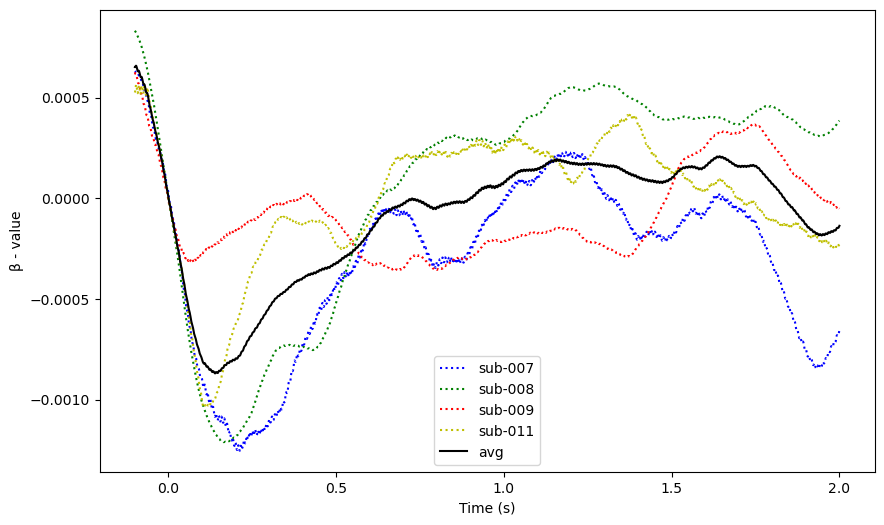

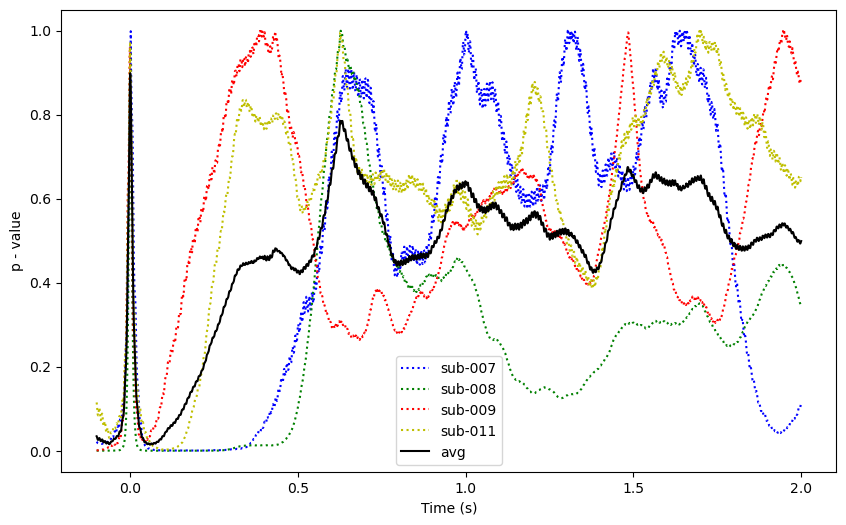

In [6]:
## plot combination of evoked
evo_comb = mne.combine_evoked([beta_vals_sub[0],beta_vals_sub[1],beta_vals_sub[2],beta_vals_sub[3]], weights=[0.25,0.25,0.25,0.25])

fig, ax = plt.subplots() #'b','g','r','y','k'
fig.set_figheight(6)
fig.set_figwidth(10)
ax.plot(beta_vals_sub[0].times,beta_vals_sub[0].data[0,:],linestyle = 'dotted', color='b', label='sub-007')
ax.plot(beta_vals_sub[1].times,beta_vals_sub[1].data[0,:],linestyle = 'dotted', color='g', label='sub-008')
ax.plot(beta_vals_sub[2].times,beta_vals_sub[2].data[0,:],linestyle = 'dotted', color='r', label='sub-009')
ax.plot(beta_vals_sub[3].times,beta_vals_sub[3].data[0,:],linestyle = 'dotted', color='y', label='sub-011')
ax.plot(evo_comb.times,evo_comb.data[0,:], color='k', label='avg')
ax.axes.set_ylabel("β \n - ← pupil size → +")
ax.axes.set_xlabel("Time (s)") 
ax.legend()
plt.show()


## plot combination of evoked
evo_comb_p = mne.combine_evoked([p_vals_sub[0],p_vals_sub[1],p_vals_sub[2],p_vals_sub[3]], weights=[0.25,0.25,0.25,0.25])

fig, ax = plt.subplots() #'b','g','r','y','k'
fig.set_figheight(6)
fig.set_figwidth(10)
ax.plot(p_vals_sub[0].times,p_vals_sub[0].data[0,:],linestyle = 'dotted', color='b', label='sub-007')
ax.plot(p_vals_sub[1].times,p_vals_sub[1].data[0,:],linestyle = 'dotted', color='g', label='sub-008')
ax.plot(p_vals_sub[2].times,p_vals_sub[2].data[0,:],linestyle = 'dotted', color='r', label='sub-009')
ax.plot(p_vals_sub[3].times,p_vals_sub[3].data[0,:],linestyle = 'dotted', color='y', label='sub-011')
ax.plot(evo_comb_p.times,evo_comb_p.data[0,:], color='k', label='avg')
ax.axes.set_ylabel("p - value") 
ax.axes.set_xlabel("Time (s)") 
ax.legend()
plt.show()

## Binning based on probability

In [37]:
# plot for each subject
sub_names = ['sub-007', 'sub-008', 'sub-009', 'sub-011']

beta_vals_sub = []
p_vals_sub = []

for subj in sub_names:
    pupil_df = pd.read_csv("/Users/scanlab/Documents/internship_luca/pupildata/pp_dfs/preprocs/with_blk/"+subj+"_pupil.csv")
    
    beta_vals_RR = []
    p_vals_RR = []

    # define stepsize
    step = 0.1
    
    for bound in np.arange(0.1,0.6,step):
        df_beh = pd.read_csv('/Users/scanlab/Documents/internship_luca/pupildata/pp_dfs/behav_data/'+subj+'.csv')
        
        ##
        # Calculate whether tone is RAND or REG based on probability
        # prob = 0.5 -> regular (REG)
        # prob = 0.0 -> random (RAND)
        ##
        df_beh["prob"] = np.abs(0.5-df_beh["probability_a"])
        # select subset of probabilities
        df_beh = df_beh.loc[(df_beh['prob']>= (bound-step)) & (df_beh['prob']<=bound)]
        
        ##
        # Combine pupil data and behavioural data
        ##
        df_beh = stim_save_segments(df_beh, groupby_nm=['block', 'segment'])
        
        df = map_stim_to_time(pupil_df, df_beh, cn_stim='stimulus', cn_ts='time', 
                             beh_cn_onset='timing_meg', beh_cn_offset='timing_offset_meg')
        df = map_columns_to_time(df, df_beh, col_to_trans=['drex_surp','block','prob'], indicator_nm='stimulus')
        
        df = map_block_to_run(df, df_beh, run_nm='run', block_nm_beh='block', block_nm='block')
        
        df = time_save_segments(df, df_beh,
                           groupby_nm=['block', 'segment'],
                           onset_nm='timing_meg',
                           offset_nm='timing_offset_meg',
                           timing_mm='time')
        df = time_save_onoff(df, onoff_nm='onoff', indicator='stimulus')
        
        # map segment specific data onto current segment
        col_to_trans = ['center_freq_a', 'center_freq_b', 'center_freq_a_oct', 'center_freq_b_oct', 'probability_a', 'probability_b']
        df = map_columns_to_time(df, df_beh, col_to_trans, indicator_nm='segment_all')
        
        fir_columns  =  ['drex_surp','onoff','prob']
        # add fir impulses to dataframe
        df = time_transform_FIR(df, 'stimulus', fir_columns)
        
        event_columns = ['FIR_onoff']
        
        dataPP = np.atleast_2d(df['pupil'].T.to_numpy())
        
        ch_names = ['pupil']
        ch_types = ['pupil']
        event_info = mne.create_info(ch_names= ch_names, ch_types= ch_types, sfreq= 1200)
        
        raw = mne.io.RawArray(dataPP, event_info)
        
        # add events for all 
        for evnt in event_columns:
            raw = add_event_from_df(raw, df, evnt)
        
        # Find events
        events = mne.find_events(raw, stim_channel='FIR_onoff')
        
        # Create epochs ('timelocked data' per 'event')
        epochs = mne.Epochs(raw, events, tmin=-0.1, tmax=2, preload=True, baseline=(-0.05,0.05))
        
        # Get the data for the 'FIR_drex_surp' channel
        fir_surprisal_data = raw.copy().pick_channels(['FIR_onoff']).get_data()
        
        # get list of bad epochs
        bad_e = []
        for idx,b in enumerate(epochs.drop_log):
            if b == ('NO_DATA',):
                bad_e.append(idx)
                # print(idx)
            elif b == ('TOO_SHORT',):
                # print(idx)
                bad_e.append(idx)
        # remove bad epochs from data
        fit_surp_no_bad = fir_surprisal_data[fir_surprisal_data > 0]
        fit_surp_no_bad = np.delete(fit_surp_no_bad, bad_e)
        
        # Perform linear regression - in this case for drex_surp
        res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
        
        # Access the beta values and related information
        beta_values = res['FIR_onoff'].beta
        t_values = res['FIR_onoff'].t_val
        p_values = res['FIR_onoff'].p_val
    
        print("Upper bound: ", bound)
        # beta_values.plot();
        
        beta_vals_RR.append(beta_values)
        p_vals_RR.append(p_values)

    beta_vals_sub.append(np.array(beta_vals_RR))
    p_vals_sub.append(np.array(p_vals_RR))

Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
768 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
768 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 768 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.191203   10.95522413 10.6021066  14.19735434 12.95357097 11.92621213
 11.68823522 11.14229038 11.17417266 11.43361801 10.69495293 14.01035694
 13.95149951 11.44546488 13.05319696 11.18203058 11.36779932 12.28184602
 11.03042392 11.99904496 11.85110185 11.1054936  11.68655197 11.78480824
 12.04546525 11.29551496 11.10151108 10.93904787 12.13959033 11.92336074
 11.53799867 11.38177463 11.0828141  11.69291407 12.80470679 11.58107431
 11.45397982 11.48600318 12.52132141 11.98331202 11.4449949  11.35426437
 11.45286335 11.25553784 11.31594944 11.23921973 11.36879324 11.07867016
 14.00210256 12.18257066 10.53402022 13.32117051 13.71105706 11.02724939
 12.29232141 13.12485064 12.75174409 12.55028287 13.68443461 11.40658279
 11.56158171 12.57338658 11.31316495 12.06124152 12.14410152 11.40858

4 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done
Upper bound:  0.1


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
3024 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
3024 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3024 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[13.86862444 13.36277492 12.26699493 ... 11.89978541 11.00416599
 12.89022927]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[13.86862444 13.36277492 12.26699493 ... 11.89978541 11.00416599
 12.89022927]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of inco

96 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Upper bound:  0.2
Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
1488 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
1488 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1488 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11.97105278 11.28515569 11.57477036 ... 10.93989275 12.17254505
 12.04657373]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11.97105278 11.28515569 11.57477036 ... 10.93989275 12.17254505
 12.04657373]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of inco

0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Upper bound:  0.30000000000000004
Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
2928 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
2928 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2928 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.04603863 11.58194967 11.17545276 ... 11.05894414 10.35477713
 10.34279612]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.04603863 11.58194967 11.17545276 ... 11.05894414 10.35477713
 10.34279612]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of inco

96 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Upper bound:  0.4
Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
2833 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
2833 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2833 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11.12523832 10.52607717 10.51378071 ... 10.08126503 10.25337253
 10.22803685]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11.12523832 10.52607717 10.51378071 ... 10.08126503 10.25337253
 10.22803685]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of inco

36 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Upper bound:  0.5
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
768 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
768 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 768 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.957472   11.92897234 13.60872283 12.84181374 12.80207418 12.49710176
 11.96147039 12.19790265 11.45583512 12.51328518 11.87807854 11.57258982
 12.01101932 12.22927715 11.52237397 11.27062665 12.29971418 11.49579579
 11.60738454 11.4600671  11.80386031 11.83807175 11.49943181 11.75374568
 11.16975222 11.78308179 11.25049709 12.13290021 12.16843994 12.69523336
 11.32451887 11.15916845 11.42626072 11.36911859 11.31556933 11.61102036
 11.04517144 12.27687119 11.55745172 11.22958911 13.64231753 11.20142273
 12.04790345 12.32501919 12.7187998  12.50569596 11.50563721 11.71959894
 11.93280819 12.24125836 16.52476301 11.62841567 10.87124447 11.2587111
 11.38287289 10.88590328 12.38118829 12.10740153 11.42491024 12.85141856
 11.49399261 10.88004224 11.7190188  10.88992183 10.84488855 10.775485

48 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done
Upper bound:  0.1


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
3072 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
3072 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3072 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[15.49667459 10.41529354 10.3190999  ... 11.66344246 11.34259226
 12.18122587]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[15.49667459 10.41529354 10.3190999  ... 11.66344246 11.34259226
 12.18122587]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of inco

48 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Upper bound:  0.2
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
1536 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
1536 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1536 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11.76147126 11.46743727 11.66622966 ... 10.91397781 12.70893752
 11.58029122]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11.76147126 11.46743727 11.66622966 ... 10.91397781 12.70893752
 11.58029122]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of inco

36 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Upper bound:  0.30000000000000004
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
3072 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
3072 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3072 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.21756403 10.91892756 14.87571093 ... 12.00387649 10.58680974
 11.00705656]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.21756403 10.91892756 14.87571093 ... 12.00387649 10.58680974
 11.00705656]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of inco

52 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Upper bound:  0.4
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
3072 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
3072 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3072 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[10.54471827 11.54635035 10.79901668 ... 10.11951599 10.72715774
 10.09809359]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[10.54471827 11.54635035 10.79901668 ... 10.11951599 10.72715774
 10.09809359]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of inco

48 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Upper bound:  0.5
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
768 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
768 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 768 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11.66683268 12.79288047 12.96270534 10.14508966 10.0573794  10.02542828
 10.37375886 13.10655199 10.16053689 12.80877387 10.107805    9.98759562
 12.56046294 12.41032782 12.35992345 11.87546316 10.64078029 10.13000827
 11.29192554 10.40393572 10.15646615 10.00843388 10.36255691 12.53064268
 10.26996368 11.49413574 12.30449028 10.28806564 12.37415308 12.43863736
 11.43215971 13.95000123 13.58184777 10.34920893 10.0844334  10.02438207
 13.20444759 12.74710902 12.50227821 12.12579046 11.99702621 14.94635419
 11.80932928 12.55623508 11.42802438 11.76236278 11.81038543 11.5332758
 16.99801586 10.41674307 14.46233216 10.49913823 13.81127939 12.64825615
 11.80948345 11.38952633 11.63078148 11.67271722 11.74364073 12.00433082
 12.27539827 11.29071864 12.3284297  11.30866013 12.46898286 11.322146

0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done
Upper bound:  0.1


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
3072 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
3072 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3072 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11.03200085 10.50411333 10.6778503  ... 12.17681189 10.79235365
 12.90786835]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11.03200085 10.50411333 10.6778503  ... 12.17681189 10.79235365
 12.90786835]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of inco

48 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Upper bound:  0.2
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
1536 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
1536 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1536 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[10.11995198 11.30516477 10.58277573 ... 11.25391578 10.96956535
 10.72255917]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[10.11995198 11.30516477 10.58277573 ... 11.25391578 10.96956535
 10.72255917]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of inco

0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Upper bound:  0.30000000000000004
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
3072 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
3072 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3072 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[17.95135811 13.13424013 11.79404474 ... 10.45447876 10.7634471
 10.60140282]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[17.95135811 13.13424013 11.79404474 ... 10.45447876 10.7634471
 10.60140282]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incomp

96 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Upper bound:  0.4
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
3072 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
3072 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3072 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.29034225 11.77309102 11.50814043 ... 12.2139443  11.39153157
 12.05366813]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.29034225 11.77309102 11.50814043 ... 12.2139443  11.39153157
 12.05366813]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of inco

88 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Upper bound:  0.5
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
672 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
672 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 672 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.36950152 11.74189932 12.2940837  11.69954674 11.7712684  12.63631816
 11.52261034 11.03285671 11.00828091 10.73744714 12.78196676 11.8415941
 11.99337527 12.04727617 12.88688193 11.26777549 11.13928835 10.98448867
 11.32411016 11.64386543 10.99958078 11.06609927 10.85946748 10.94185297
 12.02288892 13.98917416 10.77502127 10.73314329 10.88288976 10.99344628
 15.03330129 12.25114897 11.03732064 12.01391196 12.39679968 12.03921655
 11.60867376 10.74607621 12.07584873 11.79830805 10.87038738 10.69376882
 12.92761206 10.83627065 10.80113615 12.04214532 12.17407026 12.01367114
 10.22761665 10.52019315 11.30293846 10.47936156 13.35750692 12.55374625
 11.85069458 13.36357398 13.4921664  11.04817047 13.07281807 11.84311384
 10.99447681 10.62483762 13.58844936 11.59555824 10.75105972 13.345155

0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done
Upper bound:  0.1


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
2785 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
2785 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2785 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[13.0544962  14.30291742 10.52694512 ... 10.73975881 11.87732989
 10.89160697]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[13.0544962  14.30291742 10.52694512 ... 10.73975881 11.87732989
 10.89160697]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of inco

48 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Upper bound:  0.2
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
1440 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
1440 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1440 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[10.07020891 12.28807284  9.81006632 ... 10.81747054 11.39427481
 10.75739526]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[10.07020891 12.28807284  9.81006632 ... 10.81747054 11.39427481
 10.75739526]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of inco

0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done
Upper bound:  0.30000000000000004


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
2785 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
2785 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2785 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[13.33945422 10.44314173 13.17536359 ... 11.01700893 10.95435428
 12.02452246]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[13.33945422 10.44314173 13.17536359 ... 11.01700893 10.95435428
 12.02452246]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of inco

96 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Upper bound:  0.4
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
2880 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
2880 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2880 events and 2521 original time points ...


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.29162267 11.94917235 11.19201901 ... 10.79680976  9.83346849
  9.80051395]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[onset_idx, f'{prefix_fir}{col}'] = df.loc[onset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.29162267 11.94917235 11.19201901 ... 10.79680976  9.83346849
  9.80051395]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[offset_idx, f'{prefix_fir_offset}{col}'] = df.loc[offset_idx, col]
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:180: FutureWarning: Setting an item of inco

87 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/1223121907.py:91: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


Done
Upper bound:  0.5


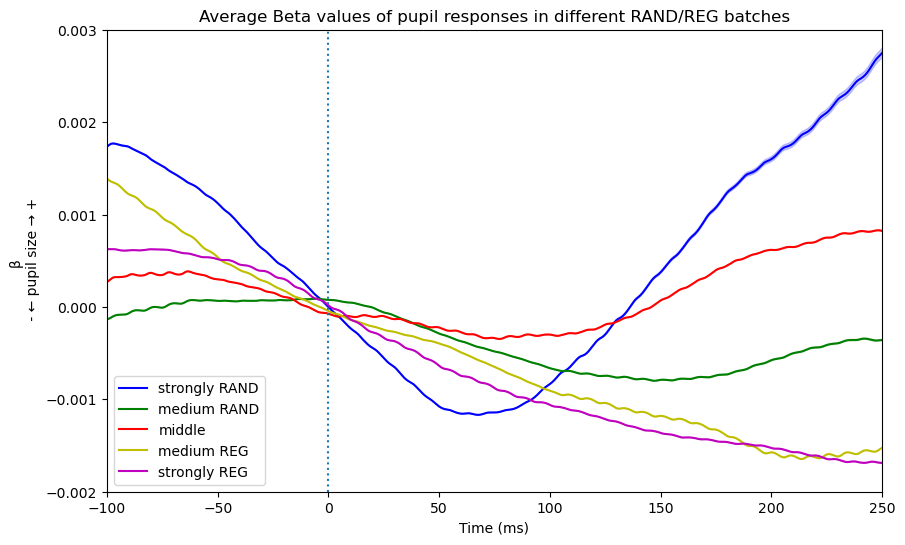

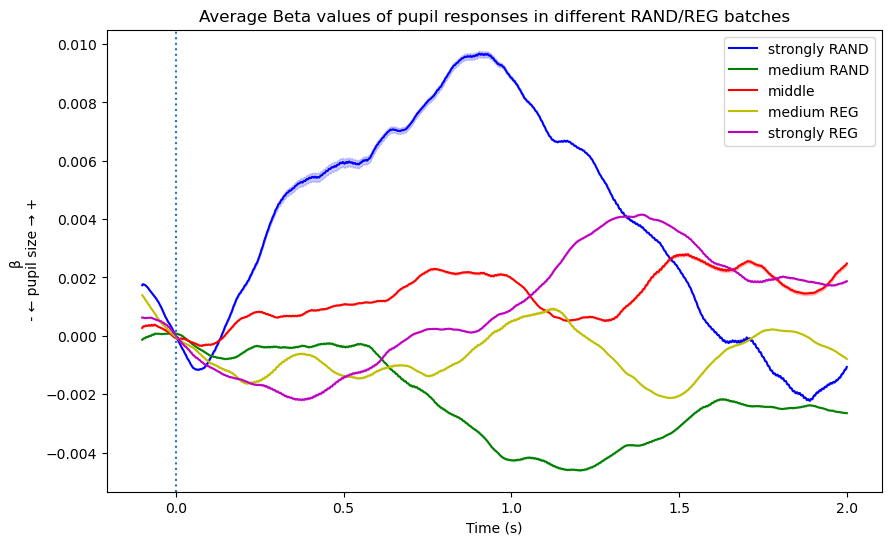

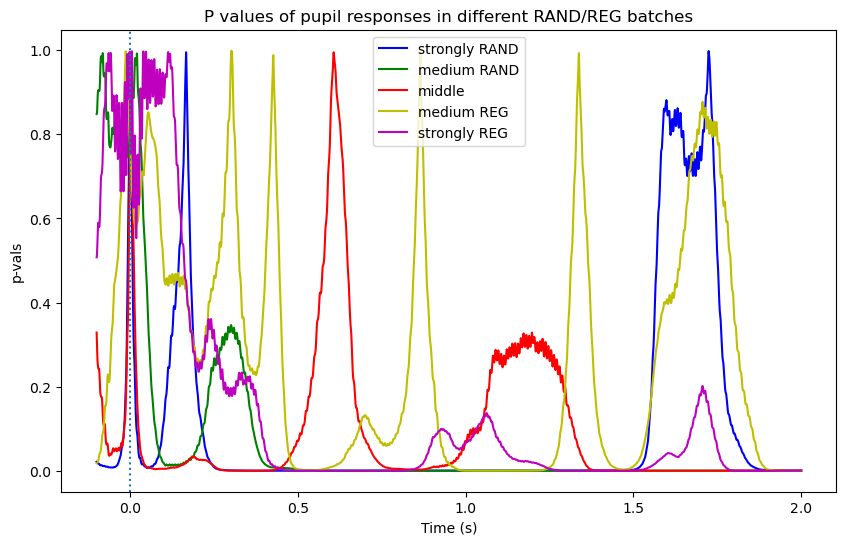

In [40]:
# Plot average of Beta values of each bin over subjects
beta_avg = np.zeros((4,5,2521))

beta_arr = np.array(beta_vals_sub)
for s in range(4):
    for b in range(5):
        beta_avg[s,b,:] = beta_arr[s][b].data[0,:]
var_avg = np.var(beta_avg,axis=0)
std_avg = np.std(beta_avg,axis=0)
beta_avg = np.mean(beta_avg,axis=0)
time_ax = beta_arr[0][0].times

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax.set_title("Average Beta values of pupil responses in different RAND/REG batches")
ax.plot(time_ax*1000, beta_avg[0,:],linestyle = 'solid', color='b', label='strongly RAND')
plt.fill_between(time_ax*1000, beta_avg[0,:]-var_avg[0,:], beta_avg[0,:]+var_avg[0,:], alpha=0.2, edgecolor='b', facecolor='b')
ax.plot(time_ax*1000, beta_avg[1,:],linestyle = 'solid', color='g', label='medium RAND')
plt.fill_between(time_ax*1000, beta_avg[1,:]-var_avg[1,:], beta_avg[1,:]+var_avg[1,:], alpha=0.2, edgecolor='g', facecolor='g')
ax.plot(time_ax*1000, beta_avg[2,:],linestyle = 'solid', color='r', label='middle')
plt.fill_between(time_ax*1000, beta_avg[2,:]-var_avg[2,:], beta_avg[2,:]+var_avg[2,:], alpha=0.2, edgecolor='r', facecolor='r')
ax.plot(time_ax*1000, beta_avg[3,:],linestyle = 'solid', color='y', label='medium REG')
plt.fill_between(time_ax*1000, beta_avg[3,:]-var_avg[3,:], beta_avg[3,:]+var_avg[3,:], alpha=0.2, edgecolor='y', facecolor='y')
ax.plot(time_ax*1000, beta_avg[4,:],linestyle = 'solid', color='m', label='strongly REG')
plt.fill_between(time_ax*1000, beta_avg[4,:]-var_avg[4,:], beta_avg[4,:]+var_avg[4,:], alpha=0.2, edgecolor='m', facecolor='m')
ax.axes.set_xlabel("Time (ms)") 
ax.axes.set_ylabel("β \n - ← pupil size → +")
ax.set_xlim([-100, 250])
ax.set_ylim([-0.002, 0.003])
ax.axvline(x=0,linestyle = 'dotted')
ax.legend()
plt.show()

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax.set_title("Average Beta values of pupil responses in different RAND/REG batches")
ax.plot(time_ax, beta_avg[0,:],linestyle = 'solid', color='b', label='strongly RAND')
plt.fill_between(time_ax, beta_avg[0,:]-var_avg[0,:], beta_avg[0,:]+var_avg[0,:], alpha=0.2, edgecolor='b', facecolor='b')
ax.plot(time_ax, beta_avg[1,:],linestyle = 'solid', color='g', label='medium RAND')
plt.fill_between(time_ax, beta_avg[1,:]-var_avg[1,:], beta_avg[1,:]+var_avg[1,:], alpha=0.2, edgecolor='g', facecolor='g')
ax.plot(time_ax, beta_avg[2,:],linestyle = 'solid', color='r', label='middle')
plt.fill_between(time_ax, beta_avg[2,:]-var_avg[2,:], beta_avg[2,:]+var_avg[2,:], alpha=0.2, edgecolor='r', facecolor='r')
ax.plot(time_ax, beta_avg[3,:],linestyle = 'solid', color='y', label='medium REG')
plt.fill_between(time_ax, beta_avg[3,:]-var_avg[3,:], beta_avg[3,:]+var_avg[3,:], alpha=0.2, edgecolor='y', facecolor='y')
ax.plot(time_ax, beta_avg[4,:],linestyle = 'solid', color='m', label='strongly REG')
plt.fill_between(time_ax, beta_avg[4,:]-var_avg[4,:], beta_avg[4,:]+var_avg[4,:], alpha=0.2, edgecolor='m', facecolor='m')
ax.axes.set_xlabel("Time (s)") 
ax.axes.set_ylabel("β \n - ← pupil size → +")
# ax.set_xlim([-0.1, 0.25])
ax.axvline(x=0,linestyle = 'dotted')
ax.legend()
plt.show()

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax.set_title("P values of pupil responses in different RAND/REG batches")
ax.plot(p_vals_RR[0].times,p_vals_RR[0].data[0,:],linestyle = 'solid', color='b', label='strongly RAND')
ax.plot(p_vals_RR[1].times,p_vals_RR[1].data[0,:],linestyle = 'solid', color='g', label='medium RAND')
ax.plot(p_vals_RR[2].times,p_vals_RR[2].data[0,:],linestyle = 'solid', color='r', label='middle')
ax.plot(p_vals_RR[3].times,p_vals_RR[3].data[0,:],linestyle = 'solid', color='y', label='medium REG')
ax.plot(p_vals_RR[4].times,p_vals_RR[4].data[0,:],linestyle = 'solid', color='m', label='strongly REG')
ax.axes.set_ylabel("p-vals") 
ax.axes.set_xlabel("Time (s)") 
ax.axvline(x=0,linestyle = 'dotted')
ax.legend()
plt.show()

## Binning based of change of probability model

In [31]:
sub_names = ['sub-007', 'sub-008', 'sub-009', 'sub-011']

beta_rand_reg = np.full([4, 2521], np.nan)
beta_reg_rand = np.full([4, 2521], np.nan)
beta_reg_reg = np.full([4, 2521], np.nan)
beta_rand_rand = np.full([4, 2521], np.nan)

beta_rand6_reg9 = np.full([4, 2521], np.nan)
beta_reg9_rand6 = np.full([4, 2521], np.nan)
beta_rand6_reg8 = np.full([4, 2521], np.nan)
beta_reg8_rand6 = np.full([4, 2521], np.nan)
beta_rand6_reg7 = np.full([4, 2521], np.nan)
beta_reg7_rand6 = np.full([4, 2521], np.nan)

p_rand_reg = np.full([4, 2521], np.nan)
p_reg_rand = np.full([4, 2521], np.nan)
p_rand_rand = np.full([4, 2521], np.nan)
p_reg_reg = np.full([4, 2521], np.nan)

nr_rera = 0
nr_rare = 0
nr_rere = 0
nr_rara = 0

nr_re9ra6 = 0
nr_ra6re9 = 0
nr_re8ra6 = 0
nr_ra6re8 = 0
nr_re7ra6 = 0
nr_ra6re7 = 0

for idx,subj in enumerate(sub_names):
    print("Current Subject: "+subj)
    # load data
    pupil_df = pd.read_csv("/Users/scanlab/Documents/internship_luca/pupildata/pp_dfs/preprocs/with_blk/"+subj+"_pupil.csv")
    df_beh_full = pd.read_csv('/Users/scanlab/Documents/internship_luca/pupildata/pp_dfs/behav_data/'+subj+'.csv')
    
    ##
    # Calculate change of probability at time of switching model
    ##
    df_beh_full["group_change"] = 0
    df_beh_full["prob"] = df_beh_full["probability_a"]-df_beh_full["probability_b"]
    df_beh_full["prob_change"] = 0
    
    for blk in range(1,25):
        for seg in range(1,10): # exclude seqment 10, as after that block is finished -> alt look at end of run?
            df_2_look = df_beh_full.loc[(df_beh_full['block']==blk) & (df_beh_full['segment']==seg)]
            idx_end = df_2_look['timing'].idxmax()
            
            # prob_1 = df_beh_full.loc[idx_end,('prob')]
            # prob_2 = df_beh_full.loc[idx_end+1,('prob')]

            prob_A_1 = df_beh_full.loc[idx_end,('probability_a')]
            prob_B_1 = df_beh_full.loc[idx_end,('probability_b')]
            prob_A_2 = df_beh_full.loc[idx_end+1,('probability_a')]
            prob_B_2 = df_beh_full.loc[idx_end+1,('probability_b')]

            if (((prob_A_1 >= prob_B_1) and (prob_A_2 >= prob_B_2)) or ((prob_A_1 <= prob_B_1) and (prob_A_1 <= prob_B_2))):
                df_beh_full.loc[idx_end,('group_change')] = 1
            elif (((prob_A_1 >= prob_B_1) and (prob_A_2 <= prob_B_2)) or ((prob_A_1 <= prob_B_1) and (prob_A_1 >= prob_B_2))):
                df_beh_full.loc[idx_end,('group_change')] = 2

            section_min1 = max([prob_A_1,prob_B_1])
            section_cur = max([prob_A_2,prob_B_2])
            rand_tolerance = 0.061
            reg_tolerance = 0.1
            bin_tolerance = 0.05

            # put data into bins, if the fulfill the probability distribution criteria
            if (((section_min1 >= 0.5 - rand_tolerance) and (section_min1 < 0.5 + rand_tolerance)) and ((section_cur > 1 - reg_tolerance ) or (section_cur < 0.0 + reg_tolerance))):
                df_beh_full.loc[idx_end,('prob_change')] = 1 # RAND-REG
            elif (((section_min1 > 1 - reg_tolerance) or (section_min1 < 0.0 + reg_tolerance)) and ((section_cur > 0.5 - rand_tolerance) and (section_cur < 0.5 + rand_tolerance))):
                df_beh_full.loc[idx_end,('prob_change')] = 2 # REG-RAND
            elif (((section_min1 > 1 - reg_tolerance) or (section_min1 < 0.0 + reg_tolerance)) and ((section_cur > 1 - reg_tolerance) or (section_cur < 0.0 + reg_tolerance))):
                df_beh_full.loc[idx_end,('prob_change')] = 3 # REG-REG
            elif (((section_min1 > 0.5 - rand_tolerance) and (section_min1 < 0.5 + rand_tolerance)) and ((section_cur > 0.5 - rand_tolerance) and (section_cur < 0.5 + rand_tolerance))):
                df_beh_full.loc[idx_end,('prob_change')] = 4 # RAND-RAND
            elif ((0.6+bin_tolerance >= section_min1 >= 0.6-bin_tolerance) and ((0.9+bin_tolerance >= section_cur >= 0.9-bin_tolerance) or (section_cur <= 0.1))):
                df_beh_full.loc[idx_end,('prob_change')] = 5 # RAND_60-REG_90
            elif (((0.9+bin_tolerance >= section_min1 >= 0.9-bin_tolerance) or (section_min1 <= 0.1)) and (0.6+bin_tolerance >= section_cur >= 0.6-bin_tolerance)):
                df_beh_full.loc[idx_end,('prob_change')] = 6 # REG_90-RAND_60
            elif ((0.6+bin_tolerance >= section_min1 >= 0.6-bin_tolerance) and ((0.8+bin_tolerance >= section_cur >= 0.8-bin_tolerance) or (0.1 <= section_cur <= 0.2))):
                df_beh_full.loc[idx_end,('prob_change')] = 7 # RAND_60-REG_80
            elif (((0.8+bin_tolerance >= section_min1 >= 0.8-bin_tolerance) or (0.1 <= section_min1 <= 0.2)) and (0.6+bin_tolerance >= section_cur >= 0.6-bin_tolerance)):
                df_beh_full.loc[idx_end,('prob_change')] = 8 # REG_80-RAND_60
            elif ((0.6+bin_tolerance >= section_min1 >= 0.6-bin_tolerance) and ((0.7+bin_tolerance >= section_cur >= 0.7-bin_tolerance) or (0.2 <= section_cur <= 0.3))):
                df_beh_full.loc[idx_end,('prob_change')] = 9 # RAND_60-REG_70
            elif (((0.7+bin_tolerance >= section_min1 >= 0.7-bin_tolerance) or (0.2 <= section_min1 <= 0.3)) and (0.6+bin_tolerance >= section_cur >= 0.6-bin_tolerance)):
                df_beh_full.loc[idx_end,('prob_change')] = 10 # REG_70-RAND_60

    # select sub-df and perform linear regression
    for rr in range(1,9):
        # select subset of df
        df_beh = df_beh_full.loc[(df_beh_full['prob_change']==rr) & (df_beh_full['group_change']==1)]

        # check if any data in df
        if df_beh.shape[0] >= 1:
            beta_values,p_values = pupil_data_lin_reg(df_beh, pupil_df)
        else:
            beta_values.data[0,:] = float('nan')
            p_values.data[0,:] = float('nan')
        
        if rr == 1: # RAND-REG
            nr_rare += df_beh.shape[0]
            beta_rand_reg[idx] = beta_values.data[0,:]
            p_rand_reg[idx] = p_values.data[0,:]
        elif rr == 2: # REG-RAND
            nr_rera += df_beh.shape[0]
            beta_reg_rand[idx] = beta_values.data[0,:]
            p_reg_rand[idx] = p_values.data[0,:]
        elif rr == 3: # REG-REG
            nr_rere += df_beh.shape[0]
            beta_reg_reg[idx] = beta_values.data[0,:]
            p_reg_reg[idx] = p_values.data[0,:]
        elif rr == 4: # RAND-RAND
            nr_rara += df_beh.shape[0]
            beta_rand_rand[idx] = beta_values.data[0,:]
            p_rand_rand[idx] = p_values.data[0,:]
        elif rr == 5: # RAND_60-REG_90
            nr_ra6re9 += df_beh.shape[0]
            beta_rand6_reg9[idx] = beta_values.data[0,:]
        elif rr == 6: # REG_90-RAND_60
            nr_re9ra6 += df_beh.shape[0]
            beta_reg9_rand6[idx] = beta_values.data[0,:]
        elif rr == 7: # RAND_60-REG_80
            nr_ra6re8 += df_beh.shape[0]
            beta_rand6_reg8[idx] = beta_values.data[0,:]
        elif rr == 8: # REG_80-RAND_60
            nr_re8ra6 += df_beh.shape[0]
            beta_reg8_rand6[idx] = beta_values.data[0,:]
        elif rr == 9: # RAND_60-REG_70
            nr_ra6re7 += df_beh.shape[0]
            beta_rand6_reg7[idx] = beta_values.data[0,:]
        elif rr == 10: # REG_70-RAND_60
            nr_re7ra6 += df_beh.shape[0]
            beta_reg7_rand6[idx] = beta_values.data[0,:]
    

Current Subject: sub-007


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
3 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
5 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
3 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
5 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
12 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 12 events and 2521 original time points ...
1 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
5 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 2521 original time points ...
1 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=114941
    Range : 0 ... 114940 =      0.000 ...    95.783 secs
Ready.
3 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done
Current Subject: sub-008


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
2 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
6 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 6 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
8 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 8 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
9 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 9 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
8 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 8 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
6 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 6 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
6 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 6 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done
Current Subject: sub-009


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
5 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
6 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 6 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
6 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 6 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
5 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
8 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 8 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
3 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=119938
    Range : 0 ... 119937 =      0.000 ...    99.948 secs
Ready.
9 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 9 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done
Current Subject: sub-011


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
3 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
2 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
4 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
10 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 10 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
6 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 6 events and 2521 original time points ...
1 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
5 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 2521 original time points ...
1 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beh['segment_all'] = np.nan


Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=109944
    Range : 0 ... 109943 =      0.000 ...    91.619 secs
Ready.
5 events found on stim channel FIR_onoff
Event IDs: [1]
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 2521 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting linear model to epochs, (5042 targets, 1 regressors)
Done


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/308373100.py:279: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  res = linear_regression(epochs, fit_surp_no_bad[fit_surp_no_bad>0, np.newaxis], names=['FIR_onoff'])


/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2138972195.py:4: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_rara = np.nanvar(beta_rand_rand,axis=0)
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2138972195.py:10: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_ra6re7 = np.nanvar(beta_rand6_reg7,axis=0)
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2138972195.py:11: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_re7ra6 = np.nanvar(beta_reg7_rand6,axis=0)
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2138972195.py:19: RuntimeWarning: Mean of empty slice
  beta_rara = np.nanmean(beta_rand_rand,axis=0)
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2138972195.py:25: RuntimeWarning: Mean of empty slice
  beta_ra6re7 = np.nanmean(beta_rand6_reg7,axis=0)
/var/folders/lv/frv9wkt970v009zl9jgxp4dh0000gp/T/ipykernel_81820/2138972195.py:26: RuntimeWarning: Mean of empty slice

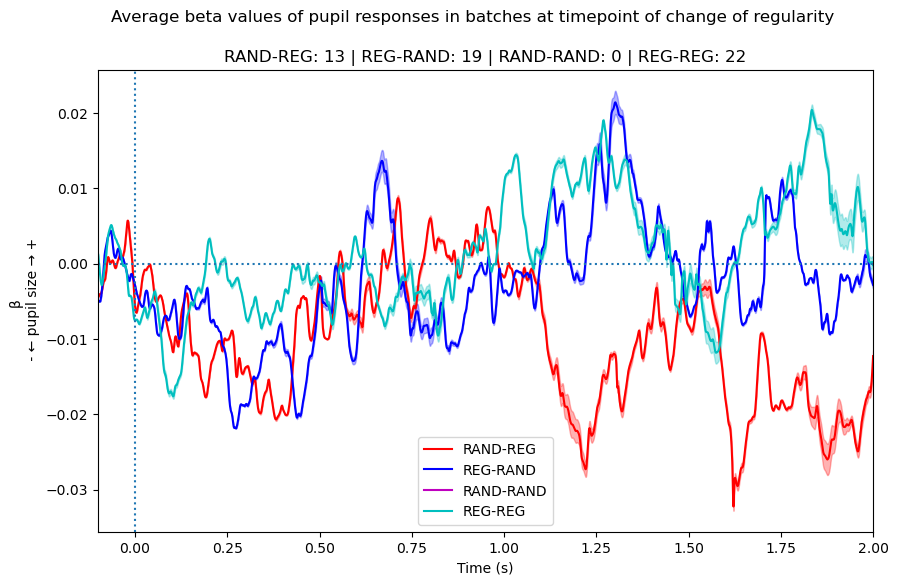

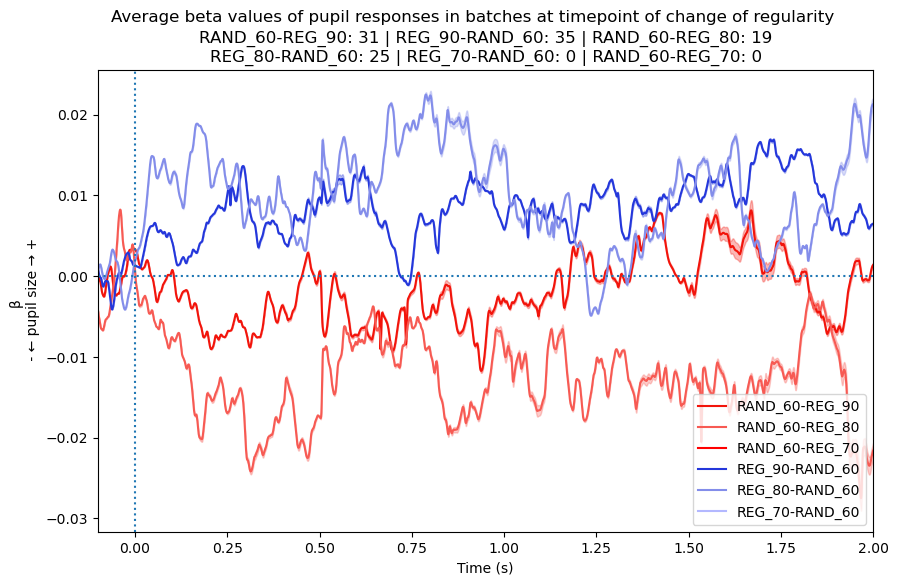

In [36]:
# Plot average of Beta values of different changing intensities over subjects for group 1
var_rera = np.nanvar(beta_reg_rand,axis=0)
var_rare = np.nanvar(beta_rand_reg,axis=0)
var_rara = np.nanvar(beta_rand_rand,axis=0)
var_rere = np.nanvar(beta_reg_reg,axis=0)
var_ra6re9 = np.nanvar(beta_rand6_reg9,axis=0)
var_re9ra6 = np.nanvar(beta_reg9_rand6,axis=0)
var_ra6re8 = np.nanvar(beta_rand6_reg8,axis=0)
var_re8ra6 = np.nanvar(beta_reg8_rand6,axis=0)
var_ra6re7 = np.nanvar(beta_rand6_reg7,axis=0)
var_re7ra6 = np.nanvar(beta_reg7_rand6,axis=0)
# std_rera = np.nanstd(beta_rera,axis=0)
# std_rare = np.nanstd(beta_rare,axis=0)
# std_rara = np.nanstd(beta_rara,axis=0)
# std_rere = np.nanstd(beta_rere,axis=0)

beta_rera = np.nanmean(beta_reg_rand,axis=0)
beta_rare = np.nanmean(beta_rand_reg,axis=0)
beta_rara = np.nanmean(beta_rand_rand,axis=0)
beta_rere = np.nanmean(beta_reg_reg,axis=0)
beta_ra6re9 = np.nanmean(beta_rand6_reg9,axis=0)
beta_re9ra6 = np.nanmean(beta_reg9_rand6,axis=0)
beta_ra6re8 = np.nanmean(beta_rand6_reg8,axis=0)
beta_re8ra6 = np.nanmean(beta_reg8_rand6,axis=0)
beta_ra6re7 = np.nanmean(beta_rand6_reg7,axis=0)
beta_re7ra6 = np.nanmean(beta_reg7_rand6,axis=0)

time_ax = beta_values.times

# plot
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax.set_subplotspec
ax.plot(time_ax, beta_rare,linestyle = 'solid', color='r', label='RAND-REG')
plt.fill_between(time_ax, beta_rare-var_rare, beta_rare+var_rare, alpha=0.3, edgecolor='r', facecolor='r')
# plt.fill_between(time_ax, beta_rare-std_rare, beta_rare+std_rare, alpha=0.2, edgecolor='r', facecolor='r')
ax.plot(time_ax, beta_rera,linestyle = 'solid', color='b', label='REG-RAND')
plt.fill_between(time_ax, beta_rera-var_rera, beta_rera+var_rera, alpha=0.3, edgecolor='b', facecolor='b')
# plt.fill_between(time_ax, beta_rera-std_rera, beta_rera+std_rera, alpha=0.2, edgecolor='b', facecolor='b')
ax.plot(time_ax, beta_rara,linestyle = 'solid', color='m', label='RAND-RAND')
plt.fill_between(time_ax, beta_rara-var_rara, beta_rara+var_rara, alpha=0.3, edgecolor='m', facecolor='m')
# plt.fill_between(time_ax, beta_rera-std_rera, beta_rera+std_rera, alpha=0.2, edgecolor='m', facecolor='m')
ax.plot(time_ax, beta_rere,linestyle = 'solid', color='c', label='REG-REG')
plt.fill_between(time_ax, beta_rere-var_rere, beta_rere+var_rere, alpha=0.3, edgecolor='c', facecolor='c')
# plt.fill_between(time_ax, beta_rere-std_rere, beta_rere+std_rere, alpha=0.2, edgecolor='c', facecolor='c')
ax.axvline(x=0,linestyle = 'dotted')
ax.axhline(y=0,linestyle = 'dotted')
ax.axes.set_xlabel("Time (s)") 
ax.axes.set_ylabel("β \n - ← pupil size → +")
ax.set_xlim([-0.1, 2])
ax.legend()
plt.title('RAND-REG: ' + str(nr_rare) + ' | REG-RAND: ' + str(nr_rera) + ' | RAND-RAND: ' + str(nr_rara) + ' | REG-REG: ' + str(nr_rere))
plt.suptitle("Average beta values of pupil responses in batches at timepoint of change of regularity", fontsize=12);
plt.show()

# plot
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax.set_subplotspec
ax.plot(time_ax, beta_ra6re9,linestyle = 'solid', color='#f2140b', label='RAND_60-REG_90')
plt.fill_between(time_ax, beta_ra6re9-var_ra6re9, beta_ra6re9+var_ra6re9, alpha=0.3, edgecolor='#f2140b', facecolor='#f2140b')
ax.plot(time_ax, beta_ra6re8,linestyle = 'solid', color='#f75a53', label='RAND_60-REG_80')
plt.fill_between(time_ax, beta_ra6re8-var_ra6re8, beta_ra6re8+var_ra6re8, alpha=0.3, edgecolor='#f75a53', facecolor='#f75a53')
ax.plot(time_ax, beta_ra6re7,linestyle = 'solid', color='#ff0000', label='RAND_60-REG_70')
plt.fill_between(time_ax, beta_ra6re7-var_ra6re7, beta_ra6re7+var_ra6re7, alpha=0.3, edgecolor='#ff0000', facecolor='#ff0000')
ax.plot(time_ax, beta_re9ra6,linestyle = 'solid', color='#2437db', label='REG_90-RAND_60')
plt.fill_between(time_ax, beta_re9ra6-var_re9ra6, beta_re9ra6+var_re9ra6, alpha=0.3, edgecolor='#2437db', facecolor='#2437db')
ax.plot(time_ax, beta_re8ra6,linestyle = 'solid', color='#838dea', label='REG_80-RAND_60')
plt.fill_between(time_ax, beta_re8ra6-var_re8ra6, beta_re8ra6+var_re8ra6, alpha=0.3, edgecolor='#838dea', facecolor='#838dea')
ax.plot(time_ax, beta_re7ra6,linestyle = 'solid', color='#b3b8ff', label='REG_70-RAND_60')
plt.fill_between(time_ax, beta_re7ra6-var_re7ra6, beta_re7ra6+var_re7ra6, alpha=0.3, edgecolor='#b3b8ff', facecolor='#b3b8ff')
ax.axvline(x=0,linestyle = 'dotted')
ax.axhline(y=0,linestyle = 'dotted')
ax.axes.set_xlabel("Time (s)") 
ax.axes.set_ylabel("β \n - ← pupil size → +")
ax.set_xlim([-0.1, 2])
ax.legend()
plt.title('RAND_60-REG_90: ' + str(nr_ra6re9) + ' | REG_90-RAND_60: ' + str(nr_re9ra6) + ' | RAND_60-REG_80: ' + str(nr_ra6re8) + '\nREG_80-RAND_60: ' + str(nr_re8ra6) + ' | REG_70-RAND_60: ' + str(nr_re7ra6) + ' | RAND_60-REG_70: ' + str(nr_ra6re7))
plt.suptitle("Average beta values of pupil responses in batches at timepoint of change of regularity", fontsize=12);
plt.show()
